# Introduction to the project

Analyze BBC news articles and cluster/classify them using unsupervised learning techiniques and compare the performance with at least one supervised learning model.

## Transfering the data from GitHub to Colab


In [16]:
!rm -rf /content/bbc_news_dtsa_5510
!rm -rf /content/tmp_data
!git clone https://github.com/rat-sparebank1/bbc_news_dtsa_5510.git

Cloning into 'bbc_news_dtsa_5510'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 44 (delta 8), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (44/44), 6.96 MiB | 29.93 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [17]:
!unzip -q bbc_news_dtsa_5510/data/learn-ai-bbc.zip -d /content/tmp_data

## Importing train and test data and read it in as pandas dataframes

In [18]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF

In [55]:
df = pd.read_csv('tmp_data/BBC News Train.csv')
X = df.Text
y = df.Category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## EDA - Make some initial description of the datasets

I have tried this as part of the EDA:
1. Inspecting the datasets using pandas info() and head()
2. Telling the articles by category
3. Building a wordcloud for some categories
4. Print word count (both train and test)



In [20]:
df.info()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business


In [21]:
print("number of articles: ", len(df.ArticleId))
print(df.Category.value_counts())

number of articles:  1490
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64


(array([336.,   0., 261.,   0.,   0., 274.,   0., 346.,   0., 273.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

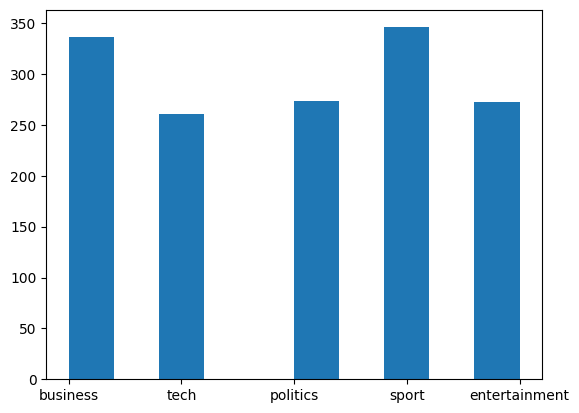

In [22]:
plt.hist(df.Category)

Trying wordclould to compare clouds between categories

In [23]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/

def generate_wordcloud(df_column):
  comment_words = ''
  stopwords = set(STOPWORDS)
  additional_stopwords = ["said", "will", "s", "us", "year"]
  for word in additional_stopwords:
    stopwords.add(word)

  for val in df_column:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

  wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

  # plot the WordCloud image
  plt.figure(figsize = (4, 4), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)

  plt.show()

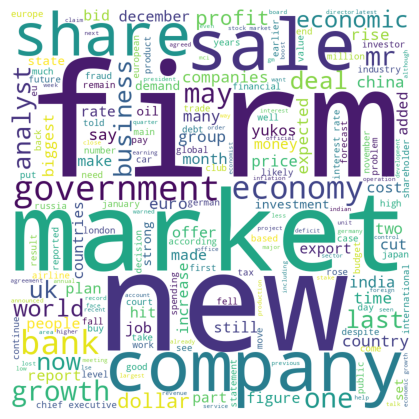

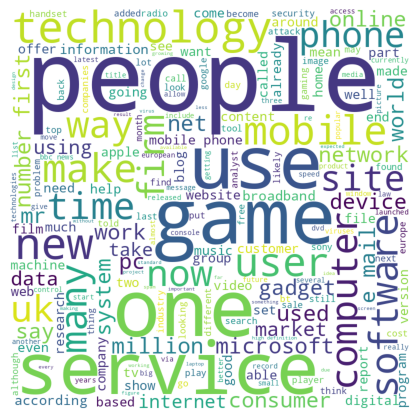

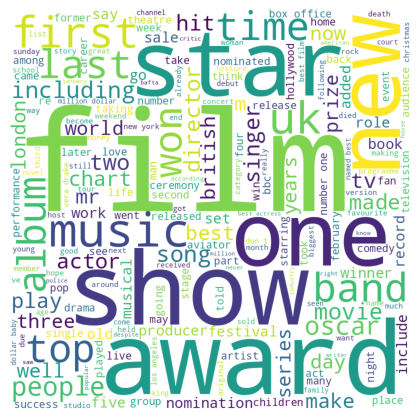

In [25]:
business_art = df.loc[df.Category == 'business', 'Text']
tech_art = df.loc[df.Category == 'tech', 'Text']
entertainment_art = df.loc[df.Category == 'entertainment', 'Text']

generate_wordcloud(business_art)
generate_wordcloud(tech_art)
generate_wordcloud(entertainment_art)

## Tokenize and vectorize text
I used this example from Scikit Learn:
https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#

In [44]:
# https://stackoverflow.com/questions/11902665/top-values-from-dictionary
vect = TfidfVectorizer()
vect.fit(df.Text)
print("Word count both train and test: ", len(vect.vocabulary_))
n_words = len(vect.vocabulary_)
tf_vect = vect.transform(X_train)
tf_vect_test = vect.transform(X_test)

print("tfidf matrix shape: ", tf_vect.shape)

Word count both train and test:  24746
tfidf matrix shape:  (1192, 24746)


## Use NMF to peform feature reduction
Even though we are asked to try different hyperparameters, when it comes to n_components I think that the only logical number there is the number of categories. Then we can predict which category an  article is.

In [45]:
# Using permutation method from the lab from Week 2 since we know the groundtruth

def label_permute_compare(ytdf,yp,n=5):
    unique_labels_string = ytdf.unique()
    pred_labels = yp
    permutations = list(itertools.permutations(range(n)))
    max_equal_labels = 0
    max_dict = {}
    max_perm = None
    for perm in permutations:
        dictionary = make_dict(unique_labels_string, perm)
        true_labels = ytdf.replace(dictionary)
        equal_labels = np.sum(true_labels == pred_labels)
        if equal_labels > max_equal_labels:
            max_perm = perm
            max_equal_labels = equal_labels
            max_dict = dictionary
    accuracy = max_equal_labels/len(true_labels)
    return max_perm, max_dict, accuracy

def make_dict(labels_string, perm):
    label_dict = {}
    for string_label, perm_label in zip(labels_string, perm):
        label_dict[string_label] = perm_label
    return label_dict




In [46]:
nmf_model = NMF(n_components=5, init='random', random_state=42)
W = nmf_model.fit_transform(tf_vect)
H = nmf_model.components_

print(W.shape)
print(H.shape)


(1192, 5)
(5, 24746)


In [47]:
y_pred = np.argmax(W, axis=1)

print(y_pred.shape)

(1192,)


In [48]:
labelorder, dictionary, acc = label_permute_compare(y_train, y_pred)
print(dictionary, acc)

{'sport': 0, 'business': 2, 'politics': 3, 'entertainment': 1, 'tech': 4} 0.8154362416107382


Lets try to make predictions using test

In [50]:
nmf_model_test = NMF(n_components=5, init='random', random_state=42)
nmf_model_test.fit(tf_vect)
W = nmf_model_test.transform(tf_vect_test)
H = nmf_model_test.components_

In [51]:
y_pred_test = np.argmax(W, axis=1)
labelorder, dictionary, acc = label_permute_compare(y_test, y_pred_test)
print(dictionary, acc)

{'entertainment': 1, 'politics': 3, 'tech': 4, 'business': 2, 'sport': 0} 0.8557046979865772


In [57]:
# Try with other loss functions:
nmf_model = NMF(n_components=5, init='random', random_state=42, beta_loss='kullback-leibler', solver='mu')
W = nmf_model.fit_transform(tf_vect)
H = nmf_model.components_
y_pred = np.argmax(W, axis=1)
labelorder, dictionary, acc = label_permute_compare(y_train, y_pred)
print(dictionary, acc)

{'sport': 2, 'business': 3, 'politics': 0, 'entertainment': 4, 'tech': 1} 0.6157718120805369


In [67]:
# Using other init. nndsvda is used when sparsity is not desired
nmf_model = NMF(n_components=5, init='nndsvda', random_state=42, beta_loss='kullback-leibler', solver='mu')
W = nmf_model.fit_transform(tf_vect)
H = nmf_model.components_
y_pred = np.argmax(W, axis=1)
labelorder, dictionary, acc = label_permute_compare(y_train, y_pred)
print(dictionary, acc)



{'sport': 1, 'business': 0, 'politics': 2, 'entertainment': 3, 'tech': 4} 0.8179530201342282


In [73]:
# Using other init, nndsvd. According to documentation, this is better for sparse matrices
nmf_model = NMF(n_components=5, init='nndsvd', random_state=42)
W = nmf_model.fit_transform(tf_vect)
H = nmf_model.components_
y_pred = np.argmax(W, axis=1)
labelorder, dictionary, acc = label_permute_compare(y_train, y_pred)
print(dictionary, acc)

{'sport': 1, 'business': 0, 'politics': 2, 'entertainment': 3, 'tech': 4} 0.8565436241610739


In [84]:
# Try with regularization
nmf_model = NMF(n_components=5, init='random', random_state=42, alpha_W=0.001)
W = nmf_model.fit_transform(tf_vect)
H = nmf_model.components_
y_pred = np.argmax(W, axis=1)
labelorder, dictionary, acc = label_permute_compare(y_train, y_pred)
print(dictionary, acc)

{'sport': 2, 'business': 0, 'politics': 1, 'entertainment': 3, 'tech': 4} 0.23741610738255034


In [85]:
# Try with regularization
nmf_model = NMF(n_components=5, init='random', random_state=42, alpha_W=0.00001, max_iter=400)
W = nmf_model.fit_transform(tf_vect)
H = nmf_model.components_
y_pred = np.argmax(W, axis=1)
labelorder, dictionary, acc = label_permute_compare(y_train, y_pred)
print(dictionary, acc)

{'sport': 0, 'business': 2, 'politics': 3, 'entertainment': 1, 'tech': 4} 0.8406040268456376


## Build a model and try to cluster the articles using the same number of categories using Agglomerative Clustering

In [52]:
agg_cluster = AgglomerativeClustering(n_clusters=5)
agg_cluster.fit_predict(tf_vect.toarray())
print(agg_cluster.labels_)

[0 1 2 ... 2 4 0]


In [53]:
labelorder, dictionary, acc = label_permute_compare(y_train, agg_cluster.labels_)
print(dictionary, acc)

{'sport': 0, 'business': 1, 'politics': 2, 'entertainment': 3, 'tech': 4} 0.8708053691275168


## Comparing using supervised learning

In [86]:
# encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# split dataset train since dataset test does not have Category
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

tfid_vect = TfidfVectorizer()
X_train_vect = tfid_vect.fit_transform(X_train)
X_test_vect = tfid_vect.transform(X_test)

# Using K-Nearest Neighbor classifier with k = 3
k = 4
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X_train_vect, y_train)
y_pred = knn_classifier.predict(X_test_vect)
true_positives = y_pred == y_test
acc = np.sum(true_positives)/len(y_test)
print(acc)


0.9328859060402684


## Answering some questions from Step 2 (from the Instructions):
**1) Think about this and answer: when you train the unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix? Why or why not?**

They may be words in the test dataset that do not appear in the train dataset and they must be tokenized too to be able to make good predictions

**2) Build a model using the matrix factorization method(s) and predict the train and test data labels. Choose any hyperparameter (e.g., number of word features) to begin with.**

I used the hyperparameters available in Scikit. They included number of components (I used the number of categories for this), regularization for W matrix, solver, loss function and number of interactions)

**3) Measure the performances on predictions from both train and test datasets. You can use accuracy, confusion matrix, etc., to inspect the performance. You can get accuracy for the test data by submitting the result to Kaggle. **

I decided to use the train dataset and split it further on  in a train and test dataset for this assignment

4) Change hyperparameter(s) and record the results. We recommend including a summary table and/or graphs.

I use accuracy using true positives/total number.
* init = random, solver = cd, beta_loss = frobenius, accuracy = 0.86

* init = random, solver = mu, beta_loss = kullback-leibler, accuracy = 0.62

* init = nndsvda, solver = mu, beta_loss = kullback-leibler, accuracy = 0.82

* init = nndsvd, solver = cd, beta_loss = frobenius, accuracy = 0.86

* alpha_W = 0.001, solver = cd, beta_loss = frobenius, accuracy = 0.24

* alpha_W = 0.00001, solver = cd, beta_loss = frobenius, accuracy = 0.84


5) Improve the model performance if you can- some ideas may include but are not limited to; using different feature extraction methods, fit models in different subsets of data, ensemble the model prediction results, etc.

I used tfidf but one could have used other vectorizer, include stopwords for example.

## Comparison Supervised and Non-Supervised methods:

I used two different non-supervised methods:
Matrix factorization achieved an accuracy of 0.86.
For Agglomerative Clustering (that is a hierarchical clustering method), achieved an accuracy of 0.87 using euclidian distance.



I used only K-Nearest Neighbor as the supervised method, and the accuracy was 0.93 (using 4 nearest neighbors)

## Conclusions:
Analyzing text requires tokenizing it and producing vectors.
Tfid vectorizer can do this for us at the same time giving more weight to the words that are not very common and reducing the words that are very frequent.

I could have used different methods to reduce dimensionality since the matrices produced when tokenizing/vectorizing have a high number of dimension and they are sparse.
Some reducing techniques that I could try could be PCA or using lists with stopwords.

The supervised learning made better predictions than the non-supervised learning methods. This may be intuitive since training a model and giving already information about the number of clusters and which element belongs to which category is additional and useful information